## Libraries and Imports

In [2]:
# 1. Basic Python Imports
import pandas as pd
import numpy as np
import pickle as pi
import os
from pathlib import Path

# 2. API Keys
from dotenv import load_dotenv

# 3. API PULL
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

# 4. Panadas_Datareader
import pandas_datareader.data as web
from pandas_datareader import data, wb
import pandas_datareader as pdr

# 5. Date Time
import datetime as dt
from datetime import datetime

# 6. Plotting
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas 
import hvplot.dask  

## Funky Functions

In [3]:
def cn_close_price_dfer(digital_asset=list):
    
    # Date information 
    startdate = datetime(2018,1,1)
    enddate = datetime.today() 
    
    # API PULL to get Data for coins
    adj_close = web.DataReader(digital_asset, 'yahoo',startdate, enddate)
    adj_close_df = adj_close.filter(like="Adj Close")
    adj_close_df.columns = adj_close_df.columns.droplevel(-2)
    
    return(adj_close_df)
    

## Code

In [8]:
stock_list = ['BRK-A']
stock_df = cn_close_price_dfer(stock_list)


index_list = ['SPY']
index_df = cn_close_price_dfer(index_list)

combo_df = pd.concat([stock_df, index_df], axis=1)

display(combo_df.head())


Symbols,BRK-A,SPY
Date,,
2018-01-02,295755,248.918167
2018-01-03,299905,250.492523
2018-01-04,300516,251.548325
2018-01-05,301525,253.224716
2018-01-08,304180,253.687729


In [9]:
# Variables
yearly_trading_days = 365 # For Crypto

# Daily Returns
# Log of percentage change
df_daily_returns = combo_df.pct_change()
df_daily_returns = df_daily_returns.dropna()

# Avg Annual Returns
avg_annual_return = df_daily_returns.mean() * yearly_trading_days
avg_annual_return.sort_values()



# Daily Returns STDDEV
df_daily_returns_stddev = df_daily_returns.std() * np.sqrt(yearly_trading_days)
df_daily_returns_stddev.sort_values()



#Sharpe Ratios
sharpe_ratios = avg_annual_return/df_daily_returns_stddev
sharpe_ratios.sort_values()


# Sharpe Graphs
sharpe_ratios.sort_values().hvplot.bar(
    hover_color='pink',
    title="BRK-A"
).opts(
    width=700,
    yformatter='%.0f',
    #color="yellow",
    bgcolor="yellow",
    fontsize={
        'title': 15, 
        'labels': 12, 
    'xticks': 10, 
    'yticks': 10,},
    padding=0.1
)

:Bars   [Symbols]   (0)

In [11]:
stock_df = stock_df.rename(
    {'BRK-A': 'Close_Price_adj'}, 
    axis=1
)

## Adding moving Average Columns

In [12]:
# Note: Adding the moving average Columns

# Create 07 days simple moving average column
stock_df['07day_SMA'] = stock_df['Close_Price_adj'].rolling(window = 7, min_periods = 1).mean()


# Create 90 days simple moving average column
stock_df['90day_SMA'] = stock_df['Close_Price_adj'].rolling(window = 90, min_periods = 1).mean()

# Create a  Signal Calendar
stock_df['Signal'] = 0.0
stock_df['Signal'] = np.where(stock_df['07day_SMA'] > stock_df['90day_SMA'], 1.0, 0.0)

# Create the position  sign
# If diff = 1, buy if -1 sell
stock_df['Position'] = stock_df['Signal'].diff()

# display first few rows
display(stock_df.head())

Symbols,Close_Price_adj,07day_SMA,90day_SMA,Signal,Position
Date,,,,,
2018-01-02,295755,295755.000000,295755.000000,0.0,NaN
2018-01-03,299905,297830.000000,297830.000000,0.0,0.0
2018-01-04,300516,298725.333333,298725.333333,0.0,0.0
2018-01-05,301525,299425.250000,299425.250000,0.0,0.0
2018-01-08,304180,300376.200000,300376.200000,0.0,0.0


## Plotting Shit

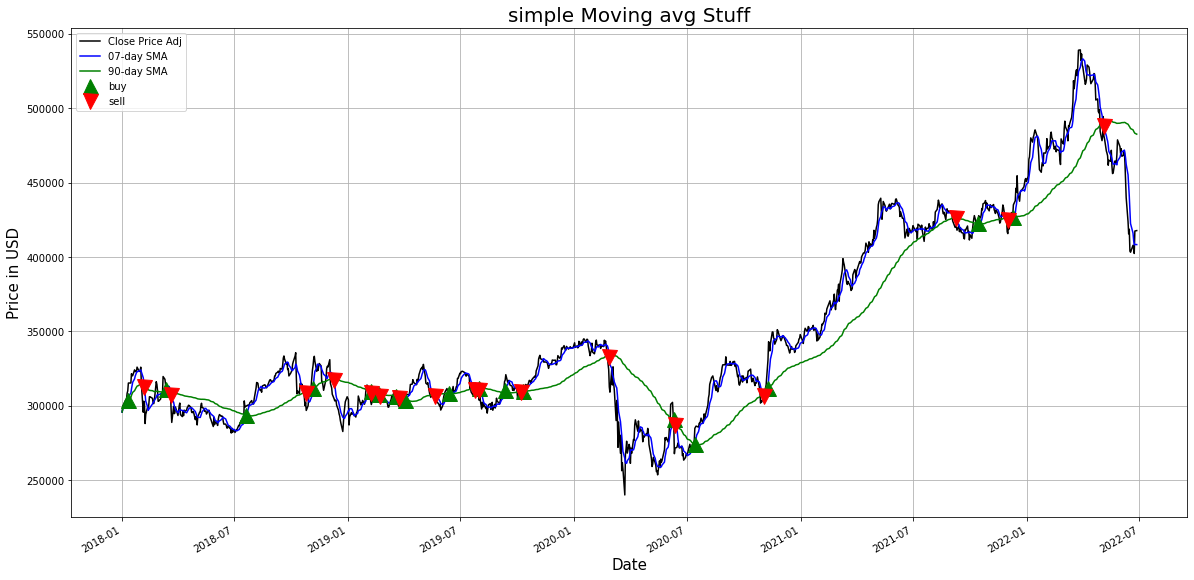

In [13]:
plt.figure(figsize = (20,10))

# plot close price, short-term and long-term moving averages 
stock_df['Close_Price_adj'].plot(color = 'k', label= 'Close Price Adj') 
stock_df['07day_SMA'].plot(color = 'b', label = '07-day SMA') 
stock_df['90day_SMA'].plot(color = 'g', label = '90-day SMA')

# plot 'buy’ signals
plt.plot(stock_df[stock_df['Position'] == 1].index, stock_df['07day_SMA'][stock_df['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')

# plot 'sell’ signals
plt.plot(
    stock_df[stock_df['Position'] == -1].index, 
    stock_df['07day_SMA'][stock_df['Position'] == -1], 
    'v', 
    markersize = 15, 
    color = 'r', 
    label = 'sell')
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('simple Moving avg Stuff', fontsize = 20)
plt.legend()
plt.grid()
plt.show()